# Import Packages and Data

In [1]:
# Import Packages
import warnings
warnings.filterwarnings("ignore")

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

#XGBoost
import xgboost as xgb

# Model Scoring/Data Prep
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import confusion_matrix

In [2]:
# Import Data
filepath = "C:\\Users\\hlmq\\OneDrive - Chevron\\Data\\DSDP\\Ames\\"

df = pd.read_csv(str(filepath)+"AmesHousing.csv")

# Feature Creation

In [3]:
# Fill this area with created columns

In [4]:
df['Bonus'] = np.where(df['SalePrice'] > 175000, 1,0)

# Modeling

## Column Preparation for Modeling

In [5]:
# Get a list of the columns in the dataframe
df.columns

Index(['Order', 'PID', 'MS SubClass', 'MS Zoning', 'Lot Frontage', 'Lot Area',
       'Street', 'Alley', 'Lot Shape', 'Land Contour', 'Utilities',
       'Lot Config', 'Land Slope', 'Neighborhood', 'Condition 1',
       'Condition 2', 'Bldg Type', 'House Style', 'Overall Qual',
       'Overall Cond', 'Year Built', 'Year Remod/Add', 'Roof Style',
       'Roof Matl', 'Exterior 1st', 'Exterior 2nd', 'Mas Vnr Type',
       'Mas Vnr Area', 'Exter Qual', 'Exter Cond', 'Foundation', 'Bsmt Qual',
       'Bsmt Cond', 'Bsmt Exposure', 'BsmtFin Type 1', 'BsmtFin SF 1',
       'BsmtFin Type 2', 'BsmtFin SF 2', 'Bsmt Unf SF', 'Total Bsmt SF',
       'Heating', 'Heating QC', 'Central Air', 'Electrical', '1st Flr SF',
       '2nd Flr SF', 'Low Qual Fin SF', 'Gr Liv Area', 'Bsmt Full Bath',
       'Bsmt Half Bath', 'Full Bath', 'Half Bath', 'Bedroom AbvGr',
       'Kitchen AbvGr', 'Kitchen Qual', 'TotRms AbvGrd', 'Functional',
       'Fireplaces', 'Fireplace Qu', 'Garage Type', 'Garage Yr Blt',
      

In [6]:
# Lists to modify for appropriate columns

# List of IVs
independent = ['Full Bath', 'Fireplaces', 'Roof Style']

# Target Variable
target = ['Bonus']

# Columns to dummy code
dummy_code_columns = ['Roof Style']

Subset specific independent variables and dependent variable for modeling

In [7]:
# Subset dataset to only columns for modeling.
X = df[independent]
y = df[target]
y.columns = ['Target']

Dummy code categorical variables

In [8]:
# This will DROP the original column and create dummies for categorical variables

for col in dummy_code_columns:
    X = pd.get_dummies(X, columns=[col])
    X.drop(X.columns[len(X.columns)-1], axis=1, inplace=True)

Train/Test split data for modeling

In [9]:
# Train,Test Split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=0)

## XGBoost

In [10]:
# Full Parameter Grid
param_grid = {
     "eta"    : [0.05, 0.10, 0.15, 0.20, 0.25, 0.30 ] ,
     "max_depth"        : [ 3, 4, 5, 6, 8, 10, 12, 15],
     "min_child_weight" : [ 1, 3, 5, 7 ],
     "gamma"            : [ 0.0, 0.1, 0.2 , 0.3, 0.4 ],
     "colsample_bytree" : [ 0.3, 0.4, 0.5 , 0.7 ]
     }


In [11]:
# Chosen Parameter Grid
param_grid = {
     "eta"    : [0.05] ,
     "max_depth"        : [10],
     "min_child_weight" : [ 5],
     "gamma"            : [0.4],
     "colsample_bytree" : [0.7]
     }

In [12]:
# XGBoost Modeling.  Cross fold validation and grid search to find best parameters.

xgboost_model = xgb.XGBClassifier()

# Save column names for future visualization
independent_columns = X_test.columns

# Initialize parameter grid for XGBoost. Shortened for brevity



# Initialize grid_search.  If it takes too long, lower the crossvalidation number
grid_search = GridSearchCV(estimator=xgboost_model,
                           param_grid=param_grid,  # parameters to be tuned
                           cv=2,
                           n_jobs=-1,  # -1 means use all available cores
                           verbose=2,
                           )

# Perform CV search over grid of hyperparameters
grid_search.fit(X_train, y_train)

print("Best CV accuracy: {}, with parameters: {}".format(
    grid_search.best_score_, grid_search.best_params_))

cv_best_model = grid_search.best_estimator_

# Add predictions to test dataset
y_test['Prediction'] = cv_best_model.predict(X_test)

# Create residuals
y_test['Residual'] = y_test['Target']-y_test['Prediction']

Fitting 2 folds for each of 1 candidates, totalling 2 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.


Best CV accuracy: 0.8078956877288072, with parameters: {'colsample_bytree': 0.7, 'eta': 0.05, 'gamma': 0.4, 'max_depth': 10, 'min_child_weight': 5}


[Parallel(n_jobs=-1)]: Done   2 out of   2 | elapsed:    5.2s finished


# Model Diagnostics

### Check Results

In [17]:
# Plot global model accuracy metrics
from python_packages.Categorical_Model import Categorical_Accuracy_Table as t

t.accuracy_table(y_test['Target'],y_test['Prediction'])

,Measure,Value
0,Accuracy,0.791809
1,F1_Score,0.788226
2,Precision,0.792750
3,Recall,0.791809
4,MCC,0.567747


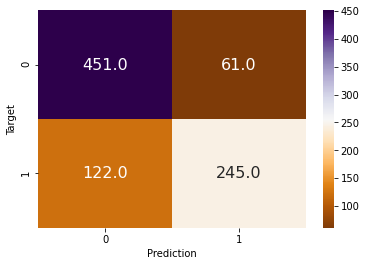

In [14]:
# Plot confusion matrix
from python_packages.Categorical_Model import Categorical_Diagnostic_Plots as t
t.confusion_matrix(y_test.iloc[:,0],y_test.iloc[:,1])

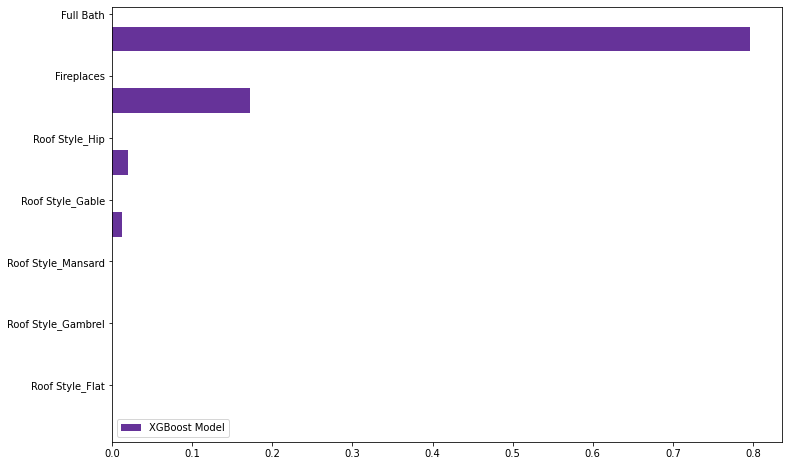

In [19]:
# Plot feature importance
from python_packages.Categorical_Model import Categorical_Diagnostic_Plots as t

t.feature_importance(cv_best_model, X_train.columns)

# Send Model Results to File

In [16]:
# Export data

#filename_submission = 'XGBoost_Classifier_Results.csv'
#data = y_test

#data.to_csv(filepath+filename_submission, sep=',', index = False)

# Appendix